In [12]:
import pandas as pd
import numpy as np
import os
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D, Flatten, BatchNormalization, Activation, Masking
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [13]:
file_name_dataset = "RAVDESS"
dataset_ravdess_dir = "../Dataset/RAVDESS/"
ravdess_dir_list = os.listdir(dataset_ravdess_dir)

In [14]:
emotion_dict = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

In [15]:
emotion_list = []
path_list = []

for dir in ravdess_dir_list:
    for audio_file in os.listdir(dataset_ravdess_dir + dir):
        emotion_segment = audio_file.split("-")[2]

        if emotion_segment in emotion_dict:
            emotion_list.append(emotion_dict[emotion_segment])
        else:
            emotion_list.append("unknown")

        audio_file_path = os.path.join(dataset_ravdess_dir, dir, audio_file)
        path_list.append(audio_file_path)

cremad_df = pd.DataFrame({'Emotion': emotion_list, 'Path': path_list})
cremad_df.to_csv("tess_df.csv", index = False)
cremad_df.head()

,Emotion,Path
0,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-01-01-...
1,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-01-02-...
2,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-02-01-...
3,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-02-02-...
4,calm,../Dataset/RAVDESS/Actor_01\03-01-02-01-01-01-...


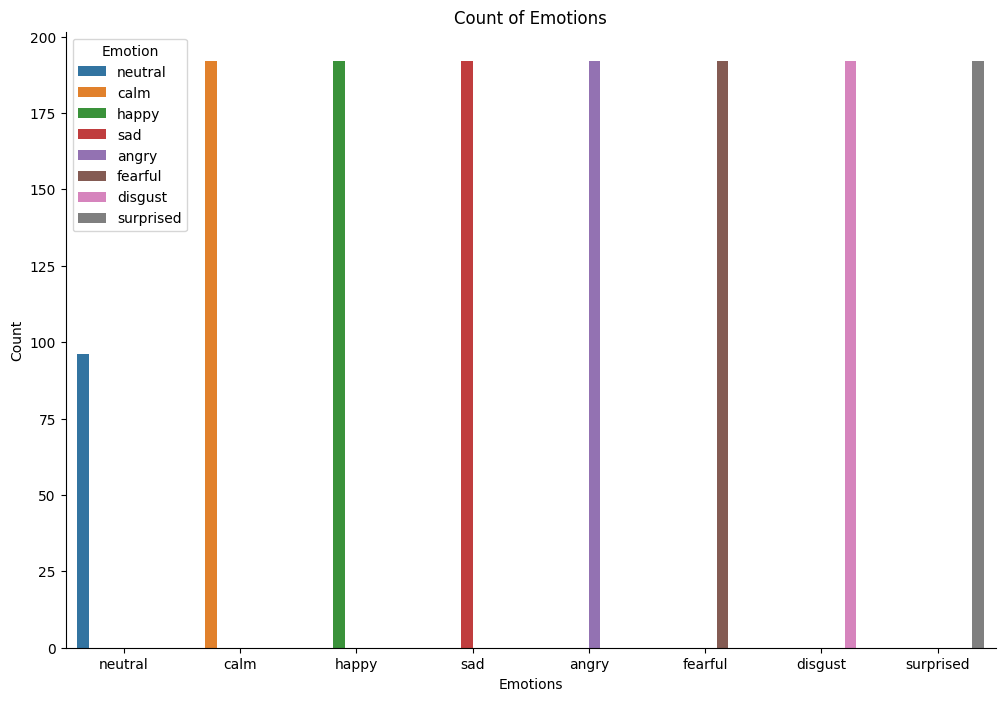

In [16]:
plt.figure(figsize=(12, 8))
plt.title('Count of Emotions')
sns.countplot(x = cremad_df.Emotion, hue = cremad_df.Emotion)
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()

In [17]:
def waveplot(data, sr, emo):
  plt.figure(figsize = (6, 1))
  plt.title(f"{emo} audio waveplot")
  librosa.display.waveshow(data, sr = sr)

def spectrogram(data, sr, emo):
  X = librosa.stft(data)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize = (6, 1))
  plt.title(f"{emo} audio spectrogram")
  librosa.display.specshow(Xdb, sr = sr, x_axis = 'time', y_axis = 'hz')

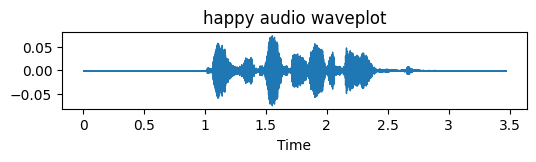

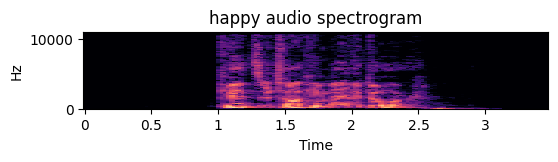

In [18]:
emotion = 'happy'

audio_file_path = np.array(cremad_df.Path[cremad_df.Emotion.str.contains(emotion)])[1]
data, sampling_rate = librosa.load(audio_file_path)

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(audio_file_path)

In [19]:
def noise(data):
  noise_amp = 0.04 * np.random.uniform() * np.amax(data)
  data = data + noise_amp * np.random.normal(size = data.shape[0])
  return data

def time_stretch(data, rate = 0.8):
  return librosa.effects.time_stretch(data, rate = rate)

def shift(data, steps_range = (-5, 5)):
  shift_range = int(np.random.uniform(steps_range[0], steps_range[1]) * 1000)
  return np.roll(data, shift_range)

def pitch_shift(data, sampling_rate, n_steps = 0.7):
  return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = n_steps)

def random_time_stretch(data, stretch_factor_range = (0.8, 1.25)):
  random_stretch_factor = np.random.uniform(stretch_factor_range[0], stretch_factor_range[1])

  augmented_data = time_stretch(data, random_stretch_factor)

  if len(augmented_data) > len(data):
    augmented_data = augmented_data[:len(data)]
  else:
    padded_augmented_data = np.zeros_like(data)
    padded_augmented_data[:len(augmented_data)] = augmented_data
    augmented_data = padded_augmented_data

  return augmented_data

def random_pitch_shift(data, sampling_rate, steps_range=(-4, 4)):
  n_steps = np.random.randint(steps_range[0], steps_range[1] + 1)  
  return pitch_shift(data, sampling_rate, n_steps)

In [20]:
def extract_mel(data, sr, n_mels=128, fmax=8000):
    mel_spec = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n_mels, fmax=fmax)
    return mel_spec;

def extract_log_mel_spec(data, sr, n_mels=128, fmax=8000):
    log_mel_spec = librosa.power_to_db(extract_mel(data, sr, n_mels, fmax))
    return log_mel_spec;

def extract_mfcc(data, sr, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y = data, sr = sr, n_mfcc=n_mfcc)
    return mfcc;

def extract_delta_mfcc(data, sr, n_mfcc=13):
    mfcc = extract_mfcc(data, sr, n_mfcc)
    delta_mfcc = librosa.feature.delta(mfcc)
    return delta_mfcc;

def extract_delta_delta_mfcc(data, sr, n_mfcc=13):
    mfcc = extract_mfcc(data, sr, n_mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    return delta2_mfcc;

def extract_zcr(data):
    zcr = librosa.feature.zero_crossing_rate(y=data)
    return zcr

def extract_rms(data):
    rms = librosa.feature.rms(y=data)
    return rms

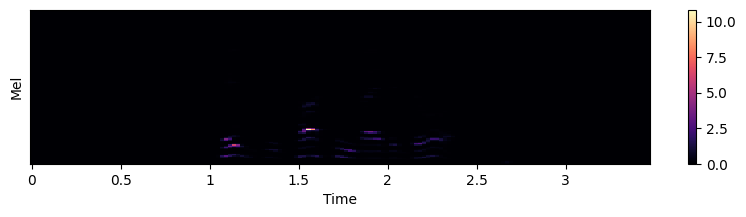

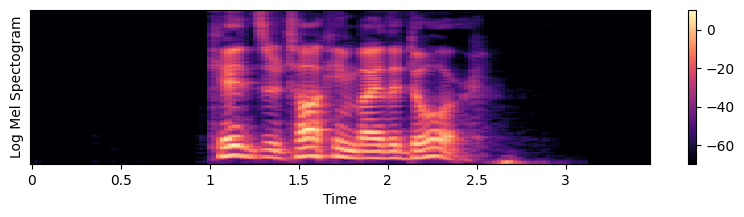

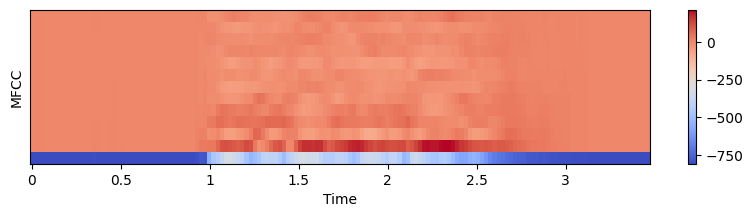

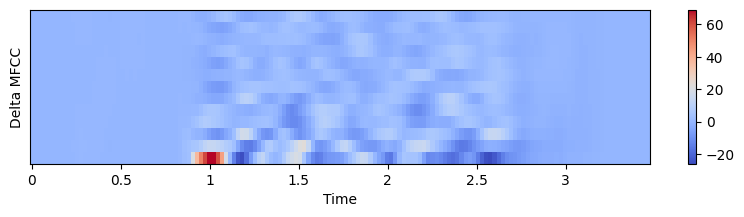

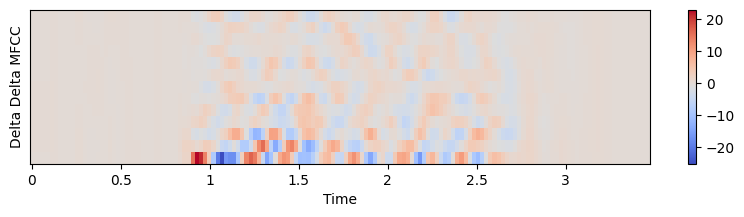

In [21]:
mel = extract_mel(data, sampling_rate, 128, 8000)
plt.figure(figsize=(10, 2))
librosa.display.specshow(mel, x_axis='time', sr = sampling_rate)
plt.ylabel('Mel')
plt.colorbar()

log_mel_spec = extract_log_mel_spec(data, sampling_rate, 128, 8000)
plt.figure(figsize=(10, 2))
librosa.display.specshow(log_mel_spec, x_axis='time', sr = sampling_rate)
plt.ylabel('Log Mel Spectogram')
plt.colorbar()

# MFCC
mfcc = extract_mfcc(data, sampling_rate, 13)
plt.figure(figsize=(10, 2))
librosa.display.specshow(mfcc, x_axis='time', sr = sampling_rate)
plt.ylabel('MFCC')
plt.colorbar()

# ΔMFCC
delta_mfcc = extract_delta_mfcc(data, sampling_rate, 13)
plt.figure(figsize=(10, 2))
librosa.display.specshow(delta_mfcc, x_axis='time', sr = sampling_rate)
plt.ylabel('Delta MFCC')
plt.colorbar()

# ΔΔMFCC
delta_delta_mfcc = extract_delta_delta_mfcc(data, sampling_rate, 13)
plt.figure(figsize=(10, 2))
librosa.display.specshow(delta_delta_mfcc, x_axis='time', sr = sampling_rate)
plt.ylabel('Delta Delta MFCC')
plt.colorbar()
plt.show()

# MFCC-based approximate entropy
# MFCC-based spectral entropy
# Three-dimensional Mel-scale frequency cepstral coefficients

In [22]:
# feature_extraction_techniques = ["MFCC", "Delta MFCC", "Delta Delta MFCC"]
# feature_extraction_techniques = ["MFCC Mean 40", "Delta MFCC Mean 40", "Delta Delta MFCC Mean 40"]
feature_extraction_techniques = ["MFCC Mean 40"]

file_name_feat_extract = " & ".join(feature_extraction_techniques)

def extract_features(data, sr, n_mfcc=40):
    # MEAN
    features = np.array([])
    mfcc = extract_mfcc(data, sr, n_mfcc).T
    delta_mfcc = extract_delta_mfcc(data, sr, n_mfcc).T
    delta_delta_mfcc = extract_delta_delta_mfcc(data, sr, n_mfcc).T
    mfcc_mean = np.mean(mfcc, axis=0)
    delta_mfcc_mean = np.mean(delta_mfcc, axis=0)
    delta_delta_mfcc_mean = np.mean(delta_delta_mfcc, axis=0)
    # mfcc_min = np.min(mfcc, axis=0)
    # mfcc_max = np.max(mfcc, axis=0)
    # mfcc_std = np.std(mfcc, axis=0)
    # zcr = np.mean(extract_zcr(data))
    # rms = np.mean(extract_rms(data))
    features = np.hstack((features, mfcc_mean))

    # ENTIRE FEATURE
    # mfcc = extract_mfcc(data, sr).T
    # delta_mfcc = extract_delta_mfcc(data, sr).T
    # delta_delta_mfcc = extract_delta_delta_mfcc(data, sr).T
    # features = np.concatenate((mfcc, delta_mfcc, delta_delta_mfcc), axis=1)
    
    return features

In [23]:
# data_augmentation_techniques = ["Noise", "Random Time Stretch", "Random Pitch Shift"]
# data_augmentation_techniques = ["Noise 0.04", "Low Speed 0.75", "Stretched 0.7", "High Speed 1.25", "Pitch Shift 0.7", "Shift (-5, 5)"]
data_augmentation_techniques = ["Noise 0.04", "Low Speed 0.75", "High Speed 1.25", "Pitch Shift 0.7", "Shift (-5, 5)"]

file_name_data_aug = " & ".join(data_augmentation_techniques)

def get_features(path):
    data, sampling_rate = librosa.load(path, duration=3, offset=0.5)

    noisy_data = noise(data)

    lowspeed_data = time_stretch(data, rate=0.75) #Ignore this
    stretched_data = time_stretch(data, rate=0.7) #Ignore this
    highspeed_data = time_stretch(data, rate=1.25) #Ignore this
    pitch_shift_data = pitch_shift(data, sampling_rate, n_steps=0.7) #Ignore this
    shift_data = shift(data, (-5, 5)) #Ignore this

    random_time_stretch_data = random_time_stretch(data, (0.8, 1.25))
    random_pitch_shift_data = random_pitch_shift(data, sampling_rate, (-4, 4))

    features = extract_features(data, sampling_rate)
    noisy_features = extract_features(noisy_data, sampling_rate)
    
    lowspeed_features = extract_features(lowspeed_data, sampling_rate) #Ignore this
    stretched_features = extract_features(stretched_data, sampling_rate) #Ignore this
    highspeed_features = extract_features(highspeed_data, sampling_rate) #Ignore this
    pitch_shift_features = extract_features(pitch_shift_data, sampling_rate) #Ignore this
    shift_features = extract_features(shift_data, sampling_rate) #Ignore this

    random_time_stretch_features = extract_features(random_time_stretch_data, sampling_rate)
    random_pitch_shift_features = extract_features(random_pitch_shift_data, sampling_rate)

    # result = np.vstack((features, noisy_features, random_time_stretch_features, random_pitch_shift_features))
    result = np.vstack((features, noisy_features, lowspeed_features, highspeed_features, pitch_shift_features, shift_features))

    return result

In [24]:
filename = file_name_dataset + " # " + file_name_feat_extract + " # " + file_name_data_aug

def create_feature_dataframe(dataframe):
    feature_list = []
    emotion_list = []

    for path, emotion in tqdm(zip(dataframe.Path, dataframe.Emotion), total=len(dataframe)):
        features = get_features(path)
        for elements in features:
            feature_list.append(elements)
            emotion_list.append(emotion)

    df = pd.DataFrame({'Emotion': emotion_list})
    df = pd.concat([df, pd.DataFrame(feature_list)], axis=1)
    df.to_csv(filename + '.csv', index=False)

    return df

In [25]:
file_exists = os.path.exists(filename + '.csv')

if file_exists:
    df = pd.read_csv(filename + '.csv')
else:
    df = create_feature_dataframe(cremad_df)

df.head()

100%|██████████| 1440/1440 [08:19<00:00,  2.88it/s]


,Emotion,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
0,neutral,-670.195435,65.063850,0.888954,14.715979,9.182164,0.660575,-3.846836,-3.583946,-12.959006,...,-2.351098,-2.504727,-3.151507,-2.190899,-3.801760,-1.813088,-1.261222,-2.144954,-4.152173,-1.779615
1,neutral,-437.411376,24.860678,7.356011,8.004017,5.143942,0.050777,-3.462119,-6.175004,-7.927267,...,-0.913083,-1.325904,-1.392386,-1.818780,-1.903436,-0.807370,-0.963922,-1.762706,-2.651064,-2.611878
2,neutral,-691.445679,62.221443,-0.300504,14.352509,8.497726,0.746647,-4.348557,-4.798969,-14.069670,...,-2.381158,-2.261819,-2.873888,-1.883212,-4.045451,-1.785669,-1.113154,-2.164787,-4.364875,-1.768830
3,neutral,-712.516907,66.194984,1.424330,16.236750,9.380598,1.506902,-4.124938,-3.517112,-13.283334,...,-1.922169,-2.280859,-3.436191,-1.829611,-4.056078,-1.664588,-0.654646,-1.566690,-4.341530,-1.645019
4,neutral,-697.627258,62.472347,-1.029173,15.987646,7.447986,-0.467146,-5.220094,-5.383532,-13.847498,...,-4.750515,-3.052244,-4.137149,-2.542254,-3.379075,-0.843549,-2.677613,-4.869622,-3.312335,-3.609416


In [26]:
X = df.iloc[:, 1:].values
Y = df['Emotion'].values

In [27]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42, shuffle = True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6912, 40), (6912, 8), (1728, 40), (1728, 8))

In [29]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6912, 40), (6912, 8), (1728, 40), (1728, 8))

In [30]:
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6912, 40, 1), (6912, 8), (1728, 40, 1), (1728, 8))

In [31]:
def create_model(model_type, epochs):
    model = Sequential()
    
    if model_type == 'GRU':
        model.add(GRU(128, input_shape=(X_train.shape[1],1), return_sequences=True))
        model.add(Dropout(0.3))
        model.add(GRU(128, return_sequences=True))
        model.add(GRU(128))
    elif model_type == 'LSTM':
        model.add(LSTM(128, input_shape=(X_train.shape[1],1), return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(128))
    elif model_type == 'BiGRU':
        model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=(X_train.shape[1],1)))
        model.add(Dropout(0.3))
        model.add(Bidirectional(GRU(128, return_sequences=True)))
        model.add(Bidirectional(GRU(128)))
    elif model_type == 'BiLSTM':
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1],1)))
        model.add(Dropout(0.3))
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(Bidirectional(LSTM(128)))
    elif model_type == 'CNN':
        model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1],1)))
        model.add(MaxPooling1D(2))
        model.add(Conv1D(128, 3, activation='relu'))
        model.add(MaxPooling1D(2))
        model.add(Conv1D(256, 3, activation='relu'))
        model.add(MaxPooling1D(2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
    else:
        raise ValueError("Invalid RNN model. Choose from 'GRU', 'LSTM', 'BiGRU', 'BiLSTM', or 'CNN'.")

    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, verbose=0, patience=3, min_lr=0.00001)
    checkpoint = ModelCheckpoint(model_type + " # " + filename + ' # Epoch 20.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_data=(X_test, y_test), callbacks=[reduce_lr, early_stop, checkpoint])

    model.save(model_type + ' # Epoch 20.h5')    
    
    return model, history

In [32]:
def evaluate_model(model):
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

In [33]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [34]:
def simplify_label(label):
    if 'angry' in label:
        return 'angry'
    elif 'disgust' in label:
        return 'disgust'
    elif 'fear' in label:
        return 'fear'
    elif 'happy' in label:
        return 'happy'
    elif 'sad' in label:
        return 'sad'
    elif 'surprise' in label:
        return 'surprise'
    elif 'neutral' in label:
        return 'neutral'
    else:
        return label

In [35]:
def create_model_summary(model_type):
    test_prediction = model_type.predict(X_test)

    prediction_actual_df = pd.DataFrame({
    'Predicted': encoder.inverse_transform(test_prediction).flatten(),
    'Actual': encoder.inverse_transform(y_test).flatten()
    })

    prediction_actual_df.head()

    modified_df = prediction_actual_df.copy()
    modified_df['Actual'] = modified_df['Actual'].apply(simplify_label)
    modified_df['Predicted'] = modified_df['Predicted'].apply(simplify_label)

    res_mat = confusion_matrix(modified_df['Actual'], modified_df['Predicted'])
    plt.figure(figsize=(10, 7))
    sns.heatmap(res_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=modified_df['Predicted'].unique(), 
                yticklabels=modified_df['Actual'].unique())
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(modified_df['Actual'], modified_df['Predicted']))

    accuracy = accuracy_score(modified_df['Actual'], modified_df['Predicted'])
    print(f"Accuracy: {round(accuracy * 100, 2)}%")

In [36]:
model_lstm, history_lstm = create_model("LSTM", 20)
model_gru, history_gru = create_model("GRU", 20)
model_bilstm, history_bilstm = create_model("BiLSTM", 20)
model_bigru, history_bigru = create_model("BiGRU", 20)
model_cnn, history_cnn = create_model("CNN", 20)

Epoch 1/20
108/108 [==============================] - ETA: 0s - loss: 1.9087 - accuracy: 0.2545
Epoch 1: val_accuracy improved from -inf to 0.31134, saving model to LSTM # RAVDESS # MFCC Mean 40 # Noise 0.04 & Low Speed 0.75 & High Speed 1.25 & Pitch Shift 0.7 & Shift (-5, 5) # Epoch 20.h5
108/108 [==============================] - 16s 94ms/step - loss: 1.9087 - accuracy: 0.2545 - val_loss: 1.8200 - val_accuracy: 0.3113 - lr: 0.0010
Epoch 2/20
107/108 [============================>.] - ETA: 0s - loss: 1.7873 - accuracy: 0.3119
Epoch 2: val_accuracy improved from 0.31134 to 0.31887, saving model to LSTM # RAVDESS # MFCC Mean 40 # Noise 0.04 & Low Speed 0.75 & High Speed 1.25 & Pitch Shift 0.7 & Shift (-5, 5) # Epoch 20.h5
108/108 [==============================] - 9s 81ms/step - loss: 1.7872 - accuracy: 0.3122 - val_loss: 1.7753 - val_accuracy: 0.3189 - lr: 0.0010
Epoch 3/20
107/108 [============================>.] - ETA: 0s - loss: 1.7293 - accuracy: 0.3283
Epoch 3: val_accuracy improv

54/54 [==============================] - 1s 25ms/step - loss: 0.5907 - accuracy: 0.8148
Test Loss: 0.5907064080238342
Test Accuracy: 0.8148148059844971


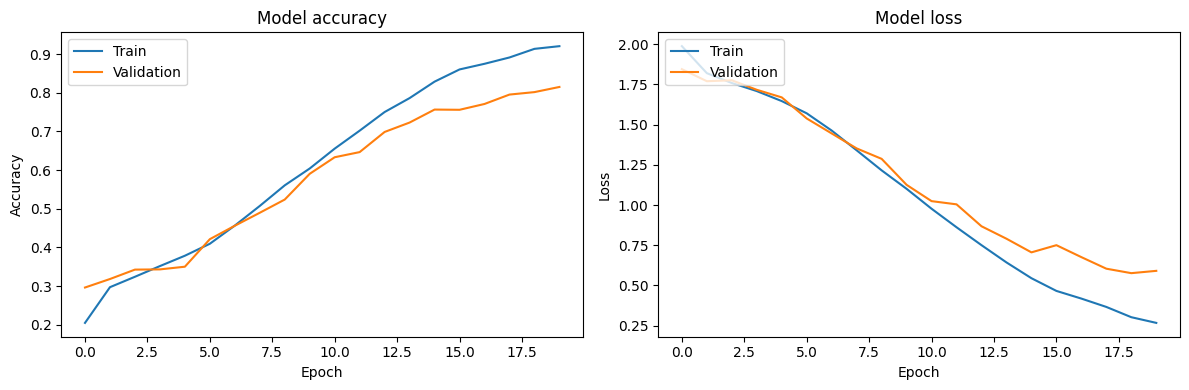

In [47]:
evaluate_model(model_gru)
plot_history(history_gru)

54/54 [==============================] - 1s 17ms/step


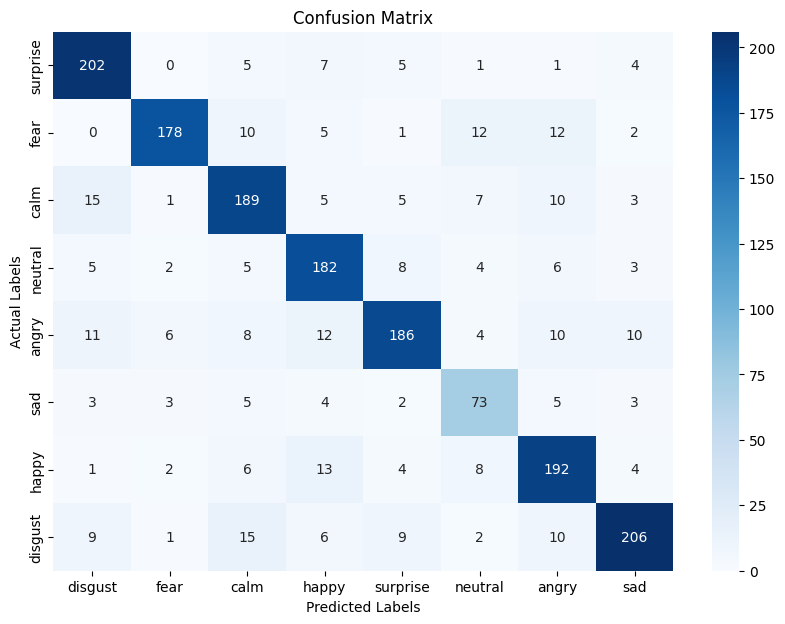

              precision    recall  f1-score   support

       angry       0.82      0.90      0.86       225
        calm       0.92      0.81      0.86       220
     disgust       0.78      0.80      0.79       235
        fear       0.78      0.85      0.81       215
       happy       0.85      0.75      0.80       247
     neutral       0.66      0.74      0.70        98
         sad       0.78      0.83      0.81       230
    surprise       0.88      0.80      0.84       258

    accuracy                           0.81      1728
   macro avg       0.81      0.81      0.81      1728
weighted avg       0.82      0.81      0.82      1728

Accuracy: 81.48%


In [48]:
create_model_summary(model_gru)

54/54 [==============================] - 2s 34ms/step - loss: 0.7254 - accuracy: 0.7494
Test Loss: 0.7253856062889099
Test Accuracy: 0.7494212985038757


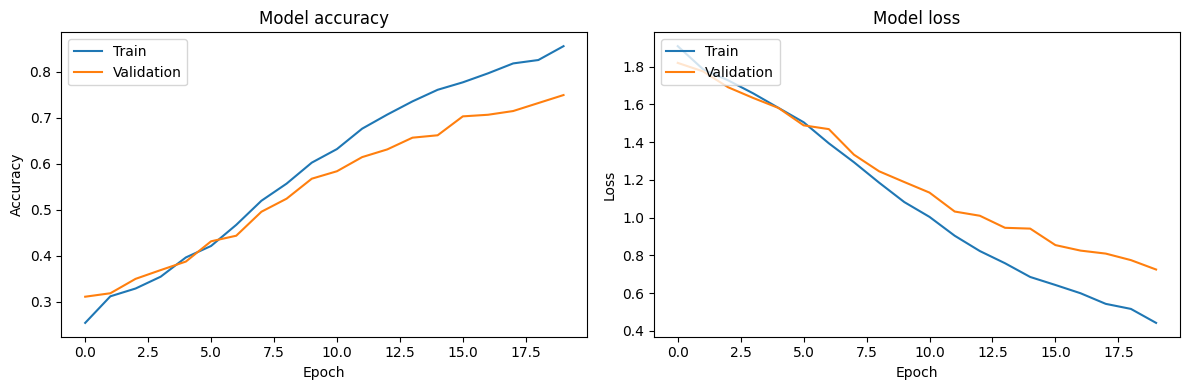

In [49]:
evaluate_model(model_lstm)
plot_history(history_lstm)

54/54 [==============================] - 2s 37ms/step


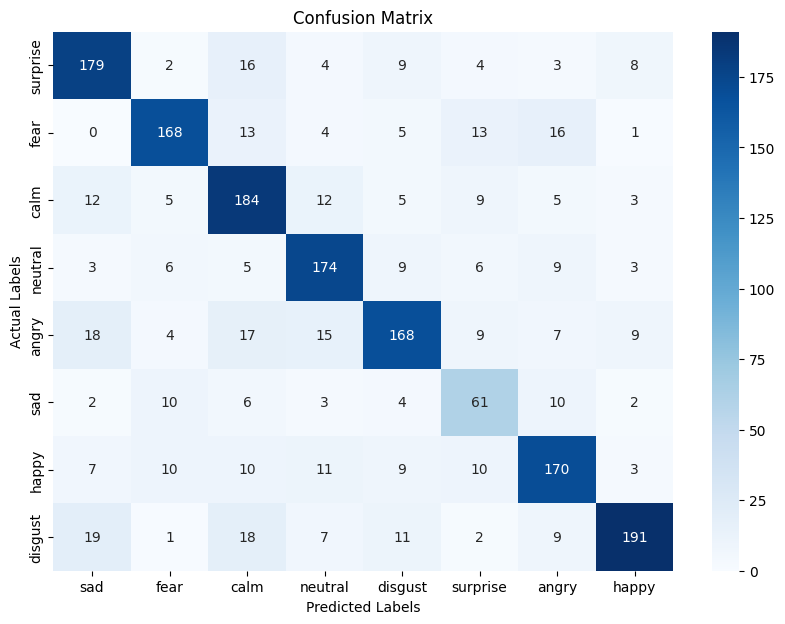

              precision    recall  f1-score   support

       angry       0.75      0.80      0.77       225
        calm       0.82      0.76      0.79       220
     disgust       0.68      0.78      0.73       235
        fear       0.76      0.81      0.78       215
       happy       0.76      0.68      0.72       247
     neutral       0.54      0.62      0.58        98
         sad       0.74      0.74      0.74       230
    surprise       0.87      0.74      0.80       258

    accuracy                           0.75      1728
   macro avg       0.74      0.74      0.74      1728
weighted avg       0.76      0.75      0.75      1728

Accuracy: 74.94%


In [50]:
create_model_summary(model_lstm)

54/54 [==============================] - 6s 119ms/step - loss: 0.4735 - accuracy: 0.8513
Test Loss: 0.47346529364585876
Test Accuracy: 0.8512731194496155


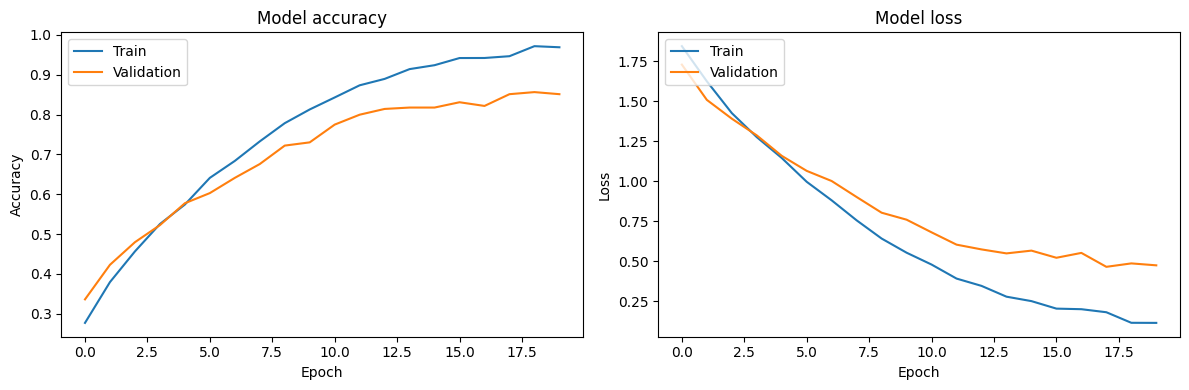

In [51]:
evaluate_model(model_bilstm)
plot_history(history_bilstm)

54/54 [==============================] - 4s 70ms/step


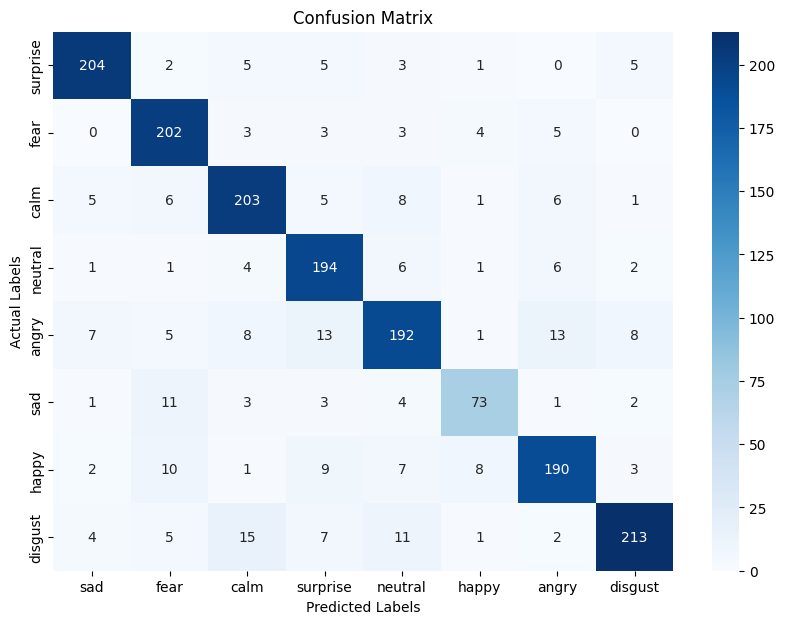

              precision    recall  f1-score   support

       angry       0.91      0.91      0.91       225
        calm       0.83      0.92      0.87       220
     disgust       0.84      0.86      0.85       235
        fear       0.81      0.90      0.85       215
       happy       0.82      0.78      0.80       247
     neutral       0.81      0.74      0.78        98
         sad       0.85      0.83      0.84       230
    surprise       0.91      0.83      0.87       258

    accuracy                           0.85      1728
   macro avg       0.85      0.85      0.85      1728
weighted avg       0.85      0.85      0.85      1728

Accuracy: 85.13%


In [52]:
create_model_summary(model_bilstm)

54/54 [==============================] - 3s 52ms/step - loss: 0.3675 - accuracy: 0.8970
Test Loss: 0.36752551794052124
Test Accuracy: 0.8969907164573669


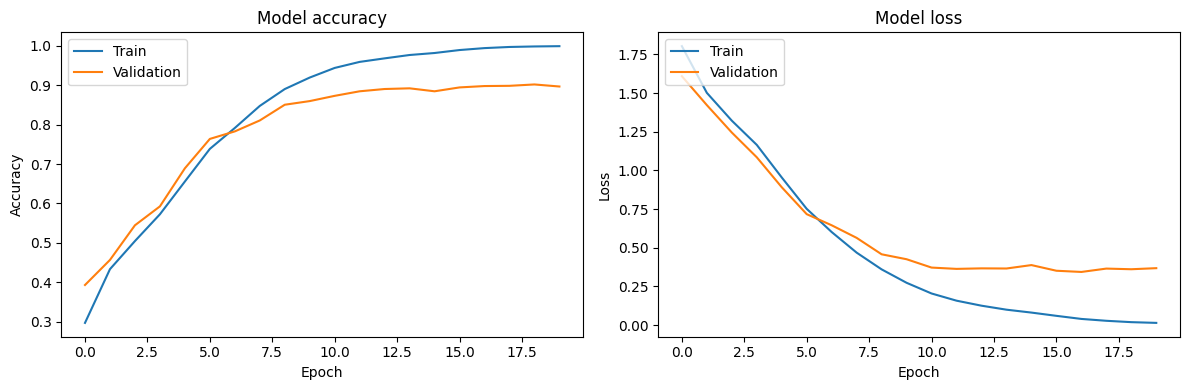

In [53]:
evaluate_model(model_bigru)
plot_history(history_bigru)

54/54 [==============================] - 2s 38ms/step


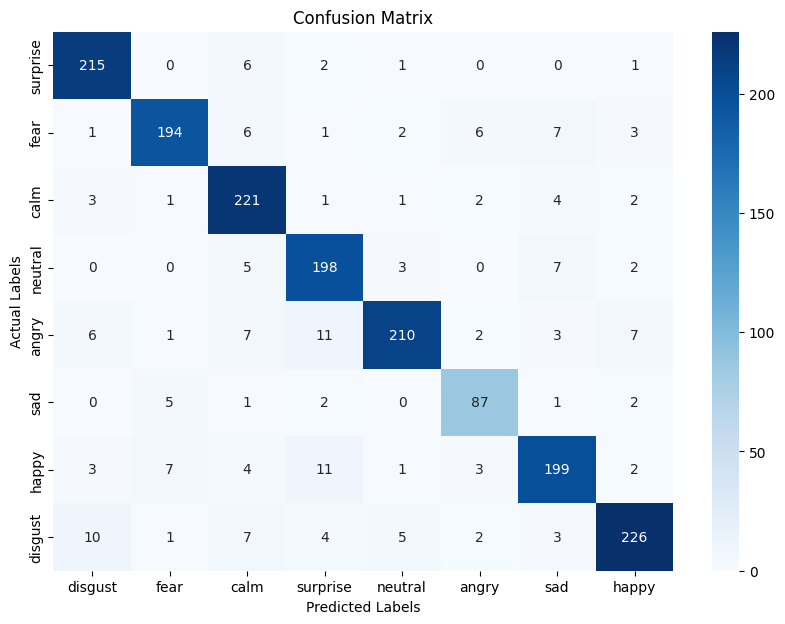

              precision    recall  f1-score   support

       angry       0.90      0.96      0.93       225
        calm       0.93      0.88      0.90       220
     disgust       0.86      0.94      0.90       235
        fear       0.86      0.92      0.89       215
       happy       0.94      0.85      0.89       247
     neutral       0.85      0.89      0.87        98
         sad       0.89      0.87      0.88       230
    surprise       0.92      0.88      0.90       258

    accuracy                           0.90      1728
   macro avg       0.89      0.90      0.90      1728
weighted avg       0.90      0.90      0.90      1728

Accuracy: 89.7%


In [54]:
create_model_summary(model_bigru)

54/54 [==============================] - 0s 5ms/step - loss: 0.3378 - accuracy: 0.9103
Test Loss: 0.3377647399902344
Test Accuracy: 0.9103009104728699


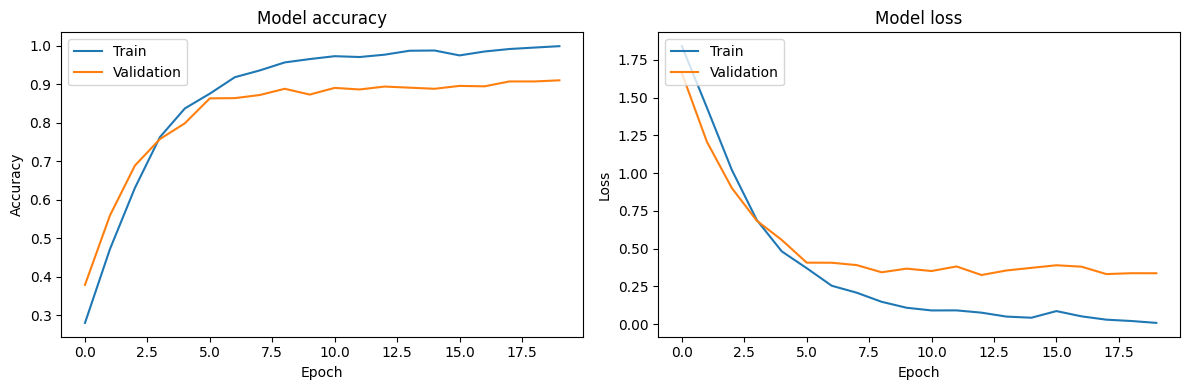

In [55]:
evaluate_model(model_cnn)
plot_history(history_cnn)

54/54 [==============================] - 0s 4ms/step


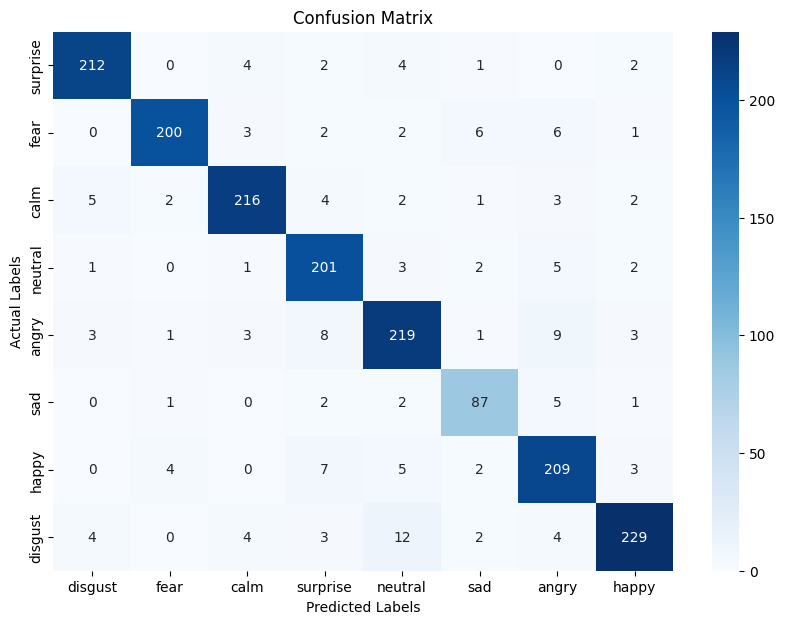

              precision    recall  f1-score   support

       angry       0.94      0.94      0.94       225
        calm       0.96      0.91      0.93       220
     disgust       0.94      0.92      0.93       235
        fear       0.88      0.93      0.91       215
       happy       0.88      0.89      0.88       247
     neutral       0.85      0.89      0.87        98
         sad       0.87      0.91      0.89       230
    surprise       0.94      0.89      0.91       258

    accuracy                           0.91      1728
   macro avg       0.91      0.91      0.91      1728
weighted avg       0.91      0.91      0.91      1728

Accuracy: 91.03%


In [56]:
create_model_summary(model_cnn)